# Private Distributed Resource Allocation Numerical Experiment Code

## 1. Set Parameters

In [2]:
if __name__ == "__main__":
    import numpy as np

    n_vars = 2
    n_cons = 2

    Q = {
        "1": np.array(
            [
                [2.875534271125623, 0.06144343163412097],
                [0.06144343163412097, 2.254218742165002],
            ]
        ),
        "2": np.array(
            [
                [3.8026179850740753, -1.1782113709237287],
                [-1.1782113709237287, 2.7730675866708934],
            ]
        ),
        "3": np.array(
            [
                [2.5699029862613805, 0.09971261279558088],
                [0.09971261279558088, 2.244252016241631],
            ]
        ),
        "4": np.array(
            [
                [2.4804809929701177, -0.7786936710712302],
                [-0.7786936710712302, 3.562713369279426],
            ]
        ),
        "5": np.array(
            [
                [2.5715134324613014, 0.6960365893732322],
                [0.6960365893732322, 3.537348963308837],
            ]
        ),
    }

    c = {
        "1": np.array([-4.219906797787817, -4.220027398318987]),
        "2": np.array([-4.090875163964497, -4.082977450732831]),
        "3": np.array([-2.71965007891482, -1.0741201930349318]),
        "4": np.array([-0.1718398346272032, -0.9580132594176947]),
        "5": np.array([-3.7061000919999154, -1.68738857823009]),
    }

    A = {
        "1": np.array(
            [
                [0.2904180608409973, 4.330880728874676],
                [3.005575058716044, 3.540362888980227],
            ]
        ),
        "2": np.array(
            [
                [1.5212112147976886, 2.6237821581611893],
                [2.1597250932105787, 1.4561457009902097],
            ]
        ),
        "3": np.array(
            [
                [0.9983689107917987, 2.571172192068058],
                [2.9620728443102124, 0.23225206359998862],
            ]
        ),
        "4": np.array(
            [
                [1.5230688458668533, 0.48836057003191935],
                [3.4211651325607844, 2.2007624686980067],
            ]
        ),
        "5": np.array(
            [
                [1.5585553804470549, 2.600340105889054],
                [2.7335513967163982, 0.9242722776276352],
            ]
        ),
    }

    b = np.array([4.847923138822793, 3.8756641168055728])

## 2. Solve Centralized Optimization

$$
\begin{split}
    \min_{\boldsymbol{x}_i \in \mathbb{R}^{n}} \quad & \sum_{i \in [5]} \left( \frac{1}{2} \boldsymbol{x}_i^\top Q_i \boldsymbol{x}_i + \boldsymbol{c}_i\boldsymbol{x}_i \right) \\
    \text{s.t.} \quad & \sum_{i \in \mathcal{I}} A_{i}\boldsymbol{x}_{i} \leq \boldsymbol{b}
\end{split}
$$

In [3]:
if __name__ == "__main__":
    import cvxpy as cp

    NODES = ["1", "2", "3", "4", "5"]
    x = {i: cp.Variable(n_vars) for i in NODES}

    cost = cp.sum([cp.quad_form(x[i], Q[i]) / 2 + c[i].T @ x[i] for i in NODES])
    constraints: list[cp.Constraint] = [
        sum([A[i] @ x[i] for i in NODES], start=cp.Constant(0)) <= b
    ]

    problem = cp.Problem(cp.Minimize(cost), constraints)

    problem.solve(solver=cp.OSQP)

    optimal_value = problem.value
    optimal_solution = {i: x[i].value for i in NODES}

    print("Optimal value:", optimal_value)
    print("Optimal solution:")
    for i in NODES:
        print(f"Node {i}: {optimal_solution[i]}")

Optimal value: -9.474506786840472
Optimal solution:
Node 1: [0.74288488 0.20711661]
Node 2: [0.95655114 1.23231216]
Node 3: [0.174483   0.03852662]
Node 4: [-1.17120148 -0.43732797]
Node 5: [ 0.55920635 -0.03871538]


## 3. Set algorithm

In [4]:
if __name__ == "__main__":
    algorithm = "proposed"  # Change to "proposed", "rsdd", or "dual_decomp" as needed

    shared_params_by_algorithm = {
        "proposed": {
            "max_iter": 3000,
            "step_size": 0.001,
            "method": "AGM",
            "solver": "OSQP",
            "with_history": True,
        },
        "rsdd": {
            "max_iter": 3000,
            "step_size": 0.5,
            "solver": "OSQP",
            "with_history": True,
            "decay_rate": 0.9,
            "penalty_factor": 1e3,
        },
        "dual_decomp": {
            "max_iter": 3000,
            "step_size": 0.1,
            "solver": "OSQP",
            "with_history": True,
            "comm_weight": 0.5,
        },
    }

## 4. Solve Distributed Optimization

In [5]:
from multiprocessing import Pool
from numpy import float64
from numpy.typing import NDArray
from pdra import ResourceAllocator


def graph_task() -> None:
    import logging

    logging.basicConfig(level=logging.INFO)

    from topolink import Graph

    node_names = ["1", "2", "3", "4", "5"]
    edge_pairs = [("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "1")]

    graph = Graph(node_names, edge_pairs)
    graph.deploy()


def worker_task(
    name: str,
    a_i: NDArray[float64],
    q_i: NDArray[float64],
    c_i: NDArray[float64],
    alg: str,
    params: dict,
    b_i: NDArray[float64],
) -> dict[str, NDArray[float64]]:
    def f(x: cp.Variable) -> cp.Expression:
        return x @ q_i @ x / 2 + c_i @ x

    allocator = ResourceAllocator.create(name, f, a_i, key=alg, **params)

    allocator.set_resource(b_i)
    allocator.run()

    return allocator.history


if __name__ == "__main__":
    shared_params = shared_params_by_algorithm[algorithm]

    with Pool(processes=len(NODES) + 1) as pool:
        graph = pool.apply_async(graph_task)

        workers = {
            i: pool.apply_async(
                worker_task,
                args=(i, A[i], Q[i], c[i], algorithm, shared_params, b / len(NODES)),
            )
            for i in NODES
        }

        graph.get()
        results = {i: worker.get() for i, worker in workers.items()}

INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:39599
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.171:38687.
INFO:topolink.graph:Node '5' joined graph 'default' from 172.26.120.171:33543.
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:38681.
INFO:topolink.graph:Node '2' joined graph 'default' from 172.26.120.171:45923.
INFO:topolink.graph:Node '4' joined graph 'default' from 172.26.120.171:33387.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'


## 5. Load Results

## 6. Plot Error Evolution

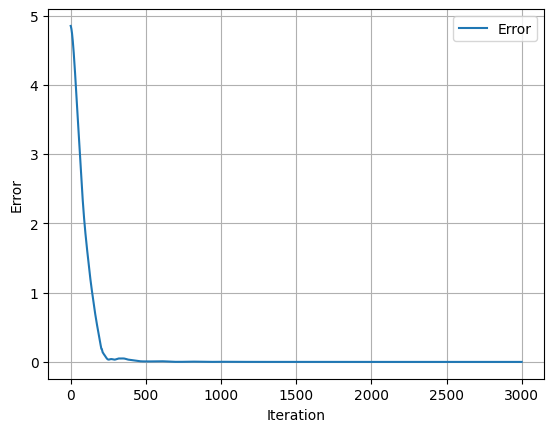

In [6]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    fig2, ax2 = plt.subplots()

    err_series = sum([result["f_i_series"] for result in results.values()]) - optimal_value  # type: ignore
    ax2.plot(err_series, label="Error")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Error")
    ax2.legend()
    ax2.grid(True)

    plt.show()

## 7. Plot Computation Time

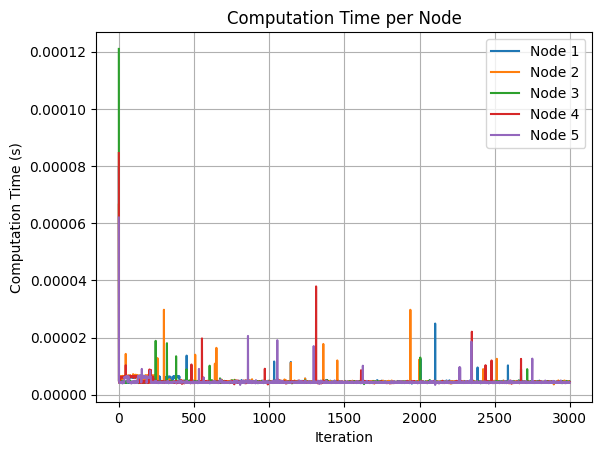

In [7]:
if __name__ == "__main__":
    fig3, ax3 = plt.subplots()

    computation_times = {i: results[i]["computation_time"] for i in NODES}
    for i in NODES:
        ax3.plot(computation_times[i], label=f"Node {i}")

    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Computation Time (s)")
    ax3.set_title("Computation Time per Node")
    ax3.grid(True)
    ax3.legend()

    plt.show()